# Projeto de Nanodegree em Machine Learning

## Análise de dados de ecocardiograma
- https://archive.ics.uci.edu/ml/datasets/Echocardiogram

In [871]:
import pandas as pd
import numpy as np
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline

In [872]:
echo_data = pd.read_csv("echo.csv", na_values='?')
echo_data = pd.DataFrame(echo_data, index=echo_data.index)
print "rodou!" # Test ok


rodou!


### Amostra de Dados iniciais

In [873]:
display(echo_data.head())
#display(echo_data)

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0,1.00,1.000,name,1.0,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0,1.70,0.588,name,1.0,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0,1.00,1.000,name,1.0,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0,1.45,0.788,name,1.0,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0,2.25,0.571,name,1.0,0.0


### Formatando os dados

Estou removendo caracteres inválidos do dataset.

Também estou removendo alguns valores incoerentes dele também, como:

- Removi valores zerados na coluna 'age at heart attack', ou, idade do ataque cardiaco, já que, provavelmente, nenhum dado de recém-nascido foi utilizado aqui;

- Por questões éticas, vamos remover a coluna 'name' também;

- De acordo com informações do dataset no site da UCI, as colunas 'mult' e 'group' também não são necessárias para nós.

#### Por questões de teste de credibilidade da database, fiz 2 arquivos de data, o data_format e o data_format limpo:

- data_format: removi as 3 colunas desnecessárias e os itens no qual o age-at-heart-attack estava zero;

- data_format_limpo: removi as 3 colunas desnecessárias e todos os itens que estavam com valores inválidos (NaN)


In [874]:
data_format = echo_data.drop(['name', 'mult', 'group'], axis= 1)
data_format = data_format.replace(np.nan, '0')
data_format = data_format.drop(data_format[data_format['age-at-heart-attack'] == '0'].index)
print "data format : {}".format(len(data_format))

data_format_limpo = echo_data.drop(['name', 'mult', 'group'], axis= 1)
data_format_limpo = data_format_limpo.dropna(axis=0, how='any')
print "data format limpo: {}".format(len(data_format_limpo))

data format : 127
data format limpo: 61


### Preparar dados estatísticos do dataset

In [875]:
def dadosPacientes(dataset): 
    # TODO: Calculate number of students
    numero_pacientes = dataset.shape[0]

    # Número de parametros (removendo também a coluna-alvo)
    numero_parametros = dataset.shape[1] - 1  

    # Número de pacientes sobreviventes ao primeiro ano após o ataque cardíaco
    numero_sobreviventes = len(dataset.loc[dataset['alive-at-1'] == 1])

    # Número de pacientes falecidos no primeiro ano após o ataque cardíaco
    numero_obitos = len(dataset.loc[dataset['alive-at-1'] == 0])

    # TODO: Calculate graduation rate
    #grad_rate = float(n_passed) / n_students * 100
    # Porcentagem de óbitos no primeiro ano após um ataque cardíaco
    porcentagem_obito = float(numero_sobreviventes) / numero_pacientes * 100

    # Print the results
    print "Número total de pacientes da triagem: {}".format(numero_pacientes)
    print "Número total de parametros: {}".format(numero_parametros)
    print "Número de pacientes sobreviventes ao primeiro ano após o ataque cardíaco: {}".format(numero_sobreviventes)
    print "Número de pacientes falecidos ao primeiro ano após o ataque cardíaco: {}".format(numero_obitos)
    print "Porcentagem de sobrevivência após ter passado um ano de um ataque cardíaco: {:.2f}%".format(porcentagem_obito)


### Estatísticas sobre os dados do dataset

In [876]:
#dadosPacientes(data_format)
dadosPacientes(data_format_limpo)

Número total de pacientes da triagem: 61
Número total de parametros: 9
Número de pacientes sobreviventes ao primeiro ano após o ataque cardíaco: 17
Número de pacientes falecidos ao primeiro ano após o ataque cardíaco: 44
Porcentagem de sobrevivência após ter passado um ano de um ataque cardíaco: 27.87%


Como vemos nos valores acima, de um total de 61 pacientes, apenas 17 sobrevivem à um ano após um ataque cardíaco, isto é, 28% do total, e é este valor que precisamos aumentar.

Uma forma melhor de enxergar quem são essas pessoas, é analisar em que faixa etária elas se encontram ou encontravam, no momento em que sofreram o ataque.

Para isso, uma nova análise será feita abaixo:

### Preparando dados para a listagem de pessoas sobreviventes e falecidas

In [877]:
def plotearSobreviventesFalecidos(dataset):

    indexPlot = dataset['age-at-heart-attack'].unique().astype(int)
    indexPlot = np.array(indexPlot)
    indexPlot.sort(axis=0)

    counter_vivo = Counter()
    counter_obito = Counter()
   
    for i in  list(dataset.index):
        idade = int(dataset['age-at-heart-attack'][i])
        sobreviveu = int(dataset['alive-at-1'][i])

        if sobreviveu == 1 :
            valor_counter_vivo = 1  
            valor_counter_obito = 0
        else :
            valor_counter_vivo = 0  
            valor_counter_obito = 1

        counter_vivo[idade] += valor_counter_vivo
        counter_obito[idade] += valor_counter_obito

    listVivo = counter_vivo.values()
    listobito = counter_obito.values()

    n_groups = len(indexPlot)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)

    bar_width = 0.35

    opacity = 0.4

    rects1 = ax.bar(index, listVivo, bar_width, alpha=opacity, color='green',                
                    label='Sobrevivente')

    rects2 = ax.bar(index + bar_width, listobito, bar_width, alpha=opacity, color='purple',               
                    label='óbito')

    
    ax.set_xlabel('Idades')
    ax.set_ylabel('Quantidade de pessoas')
    ax.set_title('Gráfico de situação de um ano após um ataque cardíaco')
    ax.set_xticks(index + bar_width / 2)
    
    ax.set_xticklabels(indexPlot)
    ax.legend()
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tight_layout()
    plt.rcParams["figure.figsize"] = [16,9]
    plt.show()      


### Gráfico de dados entre sobreviventes e óbitos após um ano de ataque cardíaco

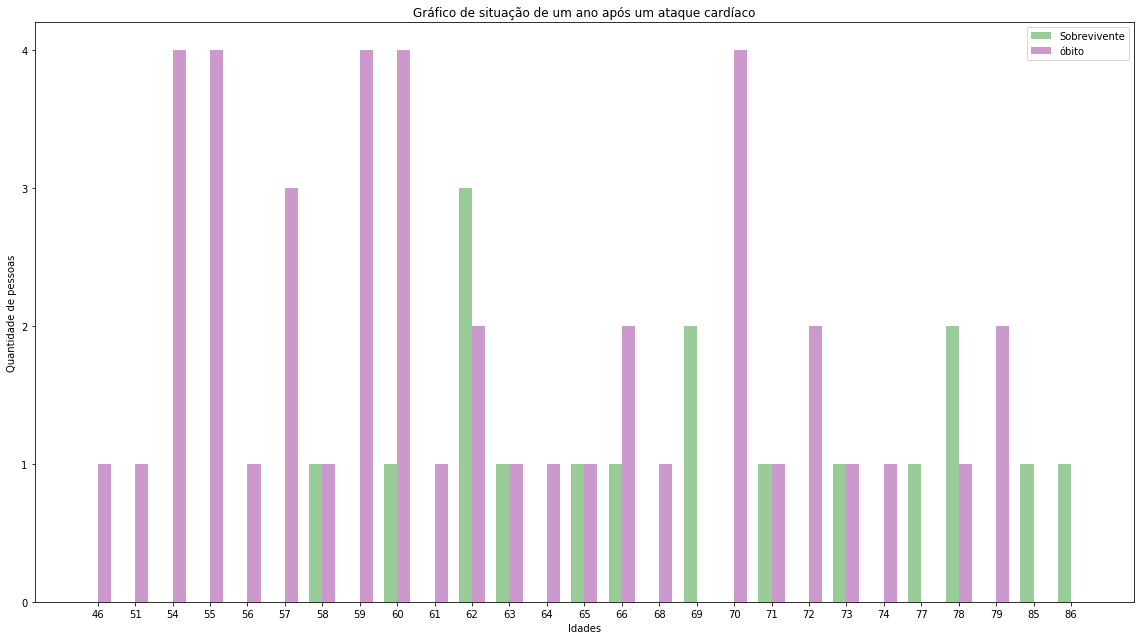

In [879]:
#plotearSobreviventesFalecidos(data_format)
plotearSobreviventesFalecidos(data_format_limpo)

## Preparando dados para os modelos de predição



In [880]:
dataset = data_format_limpo

index_teste = 2
#item de teste
teste_item = dataset.loc[index_teste]
teste_item = teste_item.drop('alive-at-1')
dataset = dataset.drop([index_teste])

# Extract feature columns
colunaAtributos = list(dataset.columns[:9])
colunaLabel = list(dataset.columns[9:])

print 'atributos do dataset: {}'.format(colunaAtributos)
print 'coluna-alvo: {}'.format(colunaLabel)

X_all = dataset[colunaAtributos]
y_all = dataset[colunaLabel]


atributos do dataset: ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score', 'wall-motion-index']
coluna-alvo: ['alive-at-1']


In [892]:
# TODO: Set the number of training points
num_train = 40

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=23)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 40 samples.
Testing set has 20 samples.


In [893]:

from sklearn.svm import SVC
clf = SVC(random_state=23)
#clf.fit(X_train, y_train) 

#clf.predict(X=teste_item)


In [894]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

    
#print y_pred
#print y_test

In [895]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    #return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}.\n".format(predict_labels(clf, X_test, y_test))
    
train_predict(clf, X_train, y_train, X_test, y_test)

Training a SVC using a training set size of 40. . .
Trained model in 0.0010 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: None.
Made predictions in 0.0002 seconds.
F1 score for test set: None.

